## Question 14

In [ ]:
using LinearAlgebra

function structured_P(L::Int; p::Float64 = 0.45, r::Float64 = 0.01)::Matrix{Float64}
    q = 1 - p - r
    P = diagm(fill(r,L)) + diagm(-1=>fill(q,L-1)) + diagm(1 => fill(p,L-1))
    P[1,1] = 1-p
    P[L,L] = 1-q
    return P
end

structured_π(L::Int; p::Float64 = 0.45, r::Float64 = 0.01)::Vector{Float64} = begin
    q = 1 - p - r
    [(p/q)^i  for i in 1:L] * (q-p) / p / (1-(p/q)^L) #Explicit expression (birth death)
end;

P = structured_P(5)
π = structured_π(5)
@show sum(π)
@show sum(π) ≈ 1
π

In [ ]:
function get_π_nullspace(P)
    #we wish to solve the equation πP - π = 0
    #i.e. we want the nullspace of (P-I)'
    basis = nullspace((P-I)')
    return basis/sum(basis)
end

get_π_nullspace(structured_P(5))

In [ ]:
function get_π_limit(P,n=100)
    return (P^n)[1,:]
end

get_π_limit(structured_P(5))

In [ ]:
function get_π_eigen(P)
    F = eigen(P')
    π = F.vectors[:,end]
    return π/sum(π)
end

get_π_eigen(structured_P(5))

In [ ]:
using StatsBase

function get_π_stats(P,sample_size=10^6)
    n = length(P[1,:])
    π = zeros(n)
    x = 1
    for i in 1:sample_size
        x = wsample(1:n,P[x,:])
        π[x] += 1
    end
    return π/sample_size
end

get_π_stats(structured_P(5))


In [ ]:
using BenchmarkTools
using StatsPlots
function evaluate()
    results = []
    for n in [2,3,4,5,10,20,30,40,50,100,200,300,400,500,1000]
        P = structured_P(n)
        π = structured_π(n)
        π1 = get_π_nullspace(P)
        π2 = get_π_eigen(P)
        π3 = get_π_limit(P,300)
        π4 = get_π_stats(P)
        results = push!(results,[norm(π-π1),norm(π-π2),norm(π-π3),norm(π-π4)])
    end
    return results
end

res = evaluate()
x = [2,3,4,5,10,20,30,40,50,100,200,300,400,500,1000]
data = collect(zip(res...))
y = hcat(collect.(data)...)
groupedbar(string.(x),y,yaxis=:log,xlabel="dimension",ylabel="error",label=hcat("nullspace","eigen","limit","stats"))
png("markov_accuracy.png")

![Accuracy comparison](markov_accuracy.png)
<!-- TODO : runtime comparison -->
In terms of accuracy, computing the eigenvector corresponding to eigenvalue 1 is the most consistently accurate for higher dimensions. Computing the nullspace is marginally better at lower dimensions, but performs worse with higher dimensions. Manually computing the limit is reasonable for low dimensions, but is not precise enough for higher dimensions, at least with only 300 iterations. Computing a random Markov chain has relatively consistent low accuracy, but this could be improved by increasing the number of samples (at the expense of compute time).

## Question 15

In [2]:
#These four convenience functions extract the state variable from the state vector
#It is assumed the layout of the vector u is u = [v_x, v_y, x, y]
state_v_x(u::Vector{Float64}) = u[1]
state_v_y(u::Vector{Float64}) = u[2]
state_x(u::Vector{Float64}) = u[3]
state_y(u::Vector{Float64}) = u[4]

"""
Computes the RHS for the one body problem. 
"""
function df_dt_one_body(u::Vector{Float64}, t::Float64)::Vector{Float64}
    M, G = 1, 1 #We take these constants as normalized. Naturally they would need to be set for physical values.
    r = sqrt(state_x(u)^2 + state_y(u)^2)
    return [-M*G*state_x(u)/r^3, -M*G*state_y(u)/r^3, state_v_x(u), state_v_y(u)]
end;

In [33]:
using Plots, Measures

function plot_trajectory( t::AbstractArray{T}, 
                        u::Vector{Vector{Float64}}; 
                        title::String = "",
                        label::Union{String, Bool} = false) where T
    x, y, v_x, v_y = state_x.(u), state_y.(u), state_v_x.(u), state_v_y.(u)

    p1 = plot(  x, y, label = label, xlabel= "X", ylabel = "Y",
                title = title*" (position)", aspectratio=1,legend=:topleft,ylim=(-7,7))
    scatter!([0], [0], ms=15, msw=0, c=:orange, shape =:star, label="Sun")
    scatter!([x[1]], [y[1]], ms=5, msw=0, c=:blue, shape =:circle, label="Earth initial position")
end;

## Question 15a

In [102]:
function euler_trajectory(h = 0.001, u_0 = [0., 1, 1.5, 0], tmax = 200)::Vector{Vector{Float64}}
    u = u_0
    t = 0
    trajectory = Vector{Vector{Float64}}(undef,ceil(Int,tmax/h)+1)
    i=1
    for t in 0:h:tmax
        trajectory[i] = u
        u = u + h*df_dt_one_body(u,t)
        i+=1
    end
    return trajectory
end

function visualise(algorithm = euler_trajectory, title = "Euler's method", prefix = "euler", hvalues = [0.01,0.001,0.0001])
    energy_plot = plot()

    for h in hvalues
        t = 0:h:200
        u = algorithm(h)
        x, y, v_x, v_y = state_x.(u), state_y.(u), state_v_x.(u), state_v_y.(u)
        #"Energy"
        r = @. sqrt(x^2 + y^2)
        E = @. 0.5*(v_x^2 + v_y^2) - 1.0/r
        plot!(energy_plot,t,E,label="h = $(h)")
        plot_trajectory(0:h:200,u,title = "$(title), h = $(h)")
        png("Q15_plots/$(prefix)_trajectory_h$(h).png")
    end

    plot(energy_plot,legend=:topleft,xlabel="time",ylabel="energy")
    png("Q15_plots/$(prefix)_energy.png")
end

visualise()

!["h=0.01"](Q15_plots/euler_trajectory_h0.01.png)
!["h=0.001"](Q15_plots/euler_trajectory_h0.001.png)
!["h=0.001"](Q15_plots/euler_trajectory_h0.0001.png)
!["Energies"](Q15_plots/euler_energy.png)

## Question 15b

In [101]:
function RK4_trajectory(h = 0.001, u_0 = [0., 1, 1.5, 0], tmax = 200)::Vector{Vector{Float64}}
    u = u_0
    t = 0
    trajectory = Vector{Vector{Float64}}(undef,ceil(Int,tmax/h)+1)
    i=1
    for t in 0:h:tmax
        trajectory[i] = u
        k1 = df_dt_one_body(u,t)
        k2 = df_dt_one_body(u + h*k1/2,t + h/2)
        k3 = df_dt_one_body(u + h*k2/2,t + h/2)
        k4 = df_dt_one_body(u + h*k3,t + h)
        u = u + h*(k1 + 2*k2 + 2*k3 + k4)/6
        i+=1
    end
    return trajectory
end

visualise(RK4_trajectory, "Runge-Kutta 4th order", "rk4")

!["h=0.01"](Q15_plots/rk4_trajectory_h0.01.png)
!["h=0.001"](Q15_plots/rk4_trajectory_h0.001.png)
!["h=0.001"](Q15_plots/rk4_trajectory_h0.0001.png)
!["Energies"](Q15_plots/rk4_energy.png)

## Question 15c

The fourth order Runge-Kutta method is more computationally intensive, due to requiring 4 computations of the derivative at each timestep. However, this results in a difference of only a few seconds in computation time, and the RK4 method is far more accurate. The RK4 method has almost perfect conservation of energy for $h=0.001$ and $h=0.0001$, and even at $h=0.01$, RK4 performs better than Euler's method with $h=0.001$. This more than makes up for the extra overhead involved with each timestep.

## Question 15d

!["orbit animation"](Q15_plots/orbits.gif)

In [ ]:
using Plots

function animate_trajectory()
    worst = euler_trajectory(0.01)
    best = RK4_trajectory(0.0001)
    x1 = state_x.(worst)
    y1 = state_y.(worst)
    x2 = state_x.(best)
    y2 = state_y.(best)

    anim = @animate for t in 0:0.5:200
        i = Int(t*100)
        plot([x1[1:i+1],x2[1:100:i*100+1]],[y1[1:i+1],y2[1:100:i*100+1]],ylim=(-7,7),xlim=(-8,6),label=hcat("Euler","RK4"))
        scatter!([0], [0], ms=15, msw=0, c=:orange, shape =:star, label="Sun")
        scatter!([x1[i+1]], [y1[i+1]],ms=5, msw=0, c=:blue, shape =:circle, label="Earth (Euler)")
        scatter!([x2[i*100+1]], [y2[i*100+1]],ms=5, msw=0, c=:orange, shape =:circle, label="Earth (RK4)")
    end

    gif(anim, "Q15_plots/orbits.gif", fps = 30)
end

animate_trajectory()

## Question 16

In [100]:
function leapfrog(h = 0.001, u_0 = [0., 1, 1.5, 0], tmax = 200)::Vector{Vector{Float64}}
    u = u_0
    t = 0
    trajectory = Vector{Vector{Float64}}(undef,ceil(Int,tmax/h)+1)
    i=1
    for t in Float64.(0:h:tmax)
        trajectory[i] = copy(u)
        v_int = u[1:2] .+ h*df_dt_one_body(u,t)[1:2]/2
        u[3] += h*v_int[1]
        u[4] += h*v_int[2]

        v_final = v_int .+ h*df_dt_one_body(u,t)[1:2]/2
        u[1] = v_final[1]
        u[2] = v_final[2]
        i+=1
    end
    return trajectory
end

visualise(leapfrog, "Leapfrog method", "leapfrog",[0.01,0.1,0.5])
visualise(euler_trajectory, "Euler's method", "euler",[0.1,0.5])
visualise(RK4_trajectory, "Runge-Kutta 4th order", "rk4",[0.1,0.5])

### Leapfrog method
<img src="Q15_plots/leapfrog_trajectory_h0.01.png" alt="h=0.01" width="200"/>
<img src="Q15_plots/leapfrog_trajectory_h0.1.png" alt="h=0.1" width="200"/>
<img src="Q15_plots/leapfrog_trajectory_h0.5.png" alt="h=0.5" width="200"/>
<img src="Q15_plots/leapfrog_energy.png" alt="h=0.5" width="200"/>

### Euler's method
<img src="Q15_plots/euler_trajectory_h0.01.png" alt="h=0.01" width="200"/>
<img src="Q15_plots/euler_trajectory_h0.1.png" alt="h=0.1" width="200"/>
<img src="Q15_plots/euler_trajectory_h0.5.png" alt="h=0.5" width="200"/>

### Runge-Kutta 4th order
<img src="Q15_plots/rk4_trajectory_h0.01.png" alt="h=0.01" width="200"/>
<img src="Q15_plots/rk4_trajectory_h0.1.png" alt="h=0.1" width="200"/>
<img src="Q15_plots/rk4_trajectory_h0.5.png" alt="h=0.5" width="200"/>

## Question 16b

Most of the expensive floating point operations occur in the function `df_dt_one_body` - i.e. calculating the force on the Earth and hence the derivative of its state vector. This function notably involves a square root and many multiplications.

Euler's method only requires one such computation per time step, but is by far the least accurate. The RK4 method computes the function at four different points for each time step, and is far more accurate than Euler's method. The leapfrog method requires two of these calculations for each time step, and is thus less expensive than RK4, but still more computationally intensive than Euler's method.

## Question 16c

We can compare the long term performance of the different solutions by plotting the radius of the Earth from the sun. A physically accurate solution should demonstrate a bounded radius with a constant period.

![comparison](Q15_plots/long_orbits.png)

The above figure shows simulations using a time resolution of $h=0.1$, up to $1000$. Euler's method quickly diverges, making larger and larger orbits. The RK4 and leapfrog methods stay relatively consistent, but begin to diverge near $t=1000$. RK4 has a slightly shorter period.

In [111]:
h = 0.1
euler = euler_trajectory(h,[0., 1, 1.5, 0], 1000)
rk4 = RK4_trajectory(h,[0., 1, 1.5, 0], 1000)
frog = leapfrog(h,[0., 1, 1.5, 0], 1000)

r1 = @. sqrt(state_x(euler)^2 + state_y(euler)^2)
r2 = @. sqrt(state_x(rk4)^2 + state_y(rk4)^2)
r3 = @. sqrt(state_x(frog)^2 + state_y(frog)^2)

plot(0:h:1000,[r1,r2,r3],label=hcat("Euler","RK4","Leapfrog"),xlabel="time",ylabel="radius",size=(1600,800))
png("Q15_plots/long_orbits.png")

## Question 16d

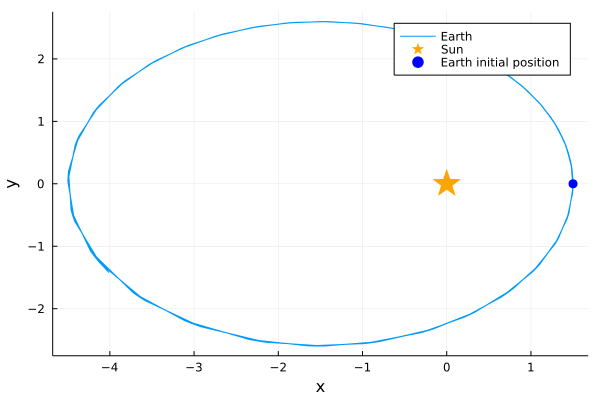

In [70]:
using DifferentialEquations
using Plots

f(u,p,t) = df_dt_one_body(u,t)

u0 = [0., 1, 1.5, 0]
tspan = (0.0,1000.0)
prob = ODEProblem(f,u0,tspan)

sol = solve(prob,Tsit5(),reltol=1e-6)

plot(state_x.(sol.u),state_y.(sol.u),label="Earth",xlabel="x",ylabel="y")
scatter!([0], [0], ms=15, msw=0, c=:orange, shape =:star, label="Sun")
scatter!([state_x(sol[1])], [state_y(sol[1])], ms=5, msw=0, c=:blue, shape =:circle, label="Earth initial position")

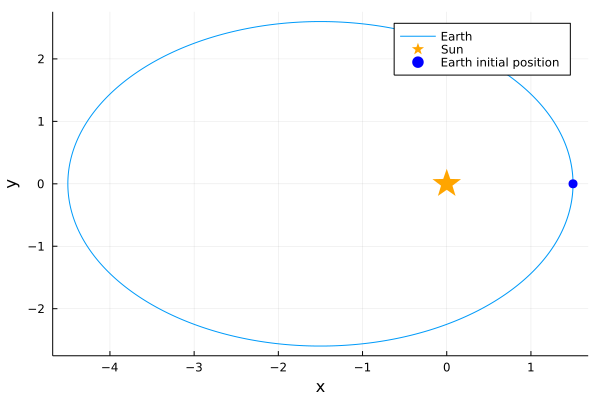

In [67]:
using DifferentialEquations
using Plots
using LinearAlgebra, ForwardDiff
f1(v,u,p,t) = df_dt_one_body([v...,u...],t)[1:2] #dv/dt
# f1(dv,v,u,p,t) = [0.1,0.1] #dv/dt
f2(v,u,p,t) = v #du/dt

u0 = [1.5, 0.0]
v0 = [0.0,1.0]
tspan = (0.0,1000.0)
prob = DynamicalODEProblem{false}(f1,f2,v0,u0,tspan)

sol = solve(prob,KahanLi6(),dt=1//10)

plot(getindex.(sol.u,3),getindex.(sol.u,4),label="Earth",xlabel="x",ylabel="y")
scatter!([0], [0], ms=15, msw=0, c=:orange, shape =:star, label="Sun")
scatter!([sol.u[1][3]], [sol.u[1][4]], ms=5, msw=0, c=:blue, shape =:circle, label="Earth initial position")


`Tsit5()` is a general purpose ODE solver. It performs reasonably well with a relative tolerance of $10^-6$, however at lower precisions such as `reltol = 1e-4` it diverges rapidly from a stable orbit. My leapfrog implementation performs slightly better, at least with h = 0.01. Leapfrog has the additional benefit that it conserves energy, whereas if `Tsit5` is run over a large enough time horizon, the solution will slowly diverge regardless of the precision.

`KahanLi6()` is a symplectic integrator, which conserves energy similarly to leapfrog. This method, however, is considerably more accurate than leapfrog, and results in an almost perfectly elliptical trajectory even with a relatively large timestep of 0.1.